In [1]:
# 주요 패키지
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt
import seaborn as sns

#
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 직접 개발한 패키지
from utils.config import CONFIG
from utils.visualize import visualize_data
from modules.input import TimeSeriesDownSampler

from training.model_training import create_lstm_autoencoder
from training.data_preprocessing import create_sequences


2024-11-30 22:41:14.476527: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 22:41:14.499630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 22:41:14.839469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 데이터 구축 파라미터
min_chunk_size = 30

# 모델 크기 파라미터
lookback = 10

# 학습 파라미터
epoch = 30
batch_size = 64

# threshold: parameter search
beta = 1


## 1. 데이터 분석 및 시각화

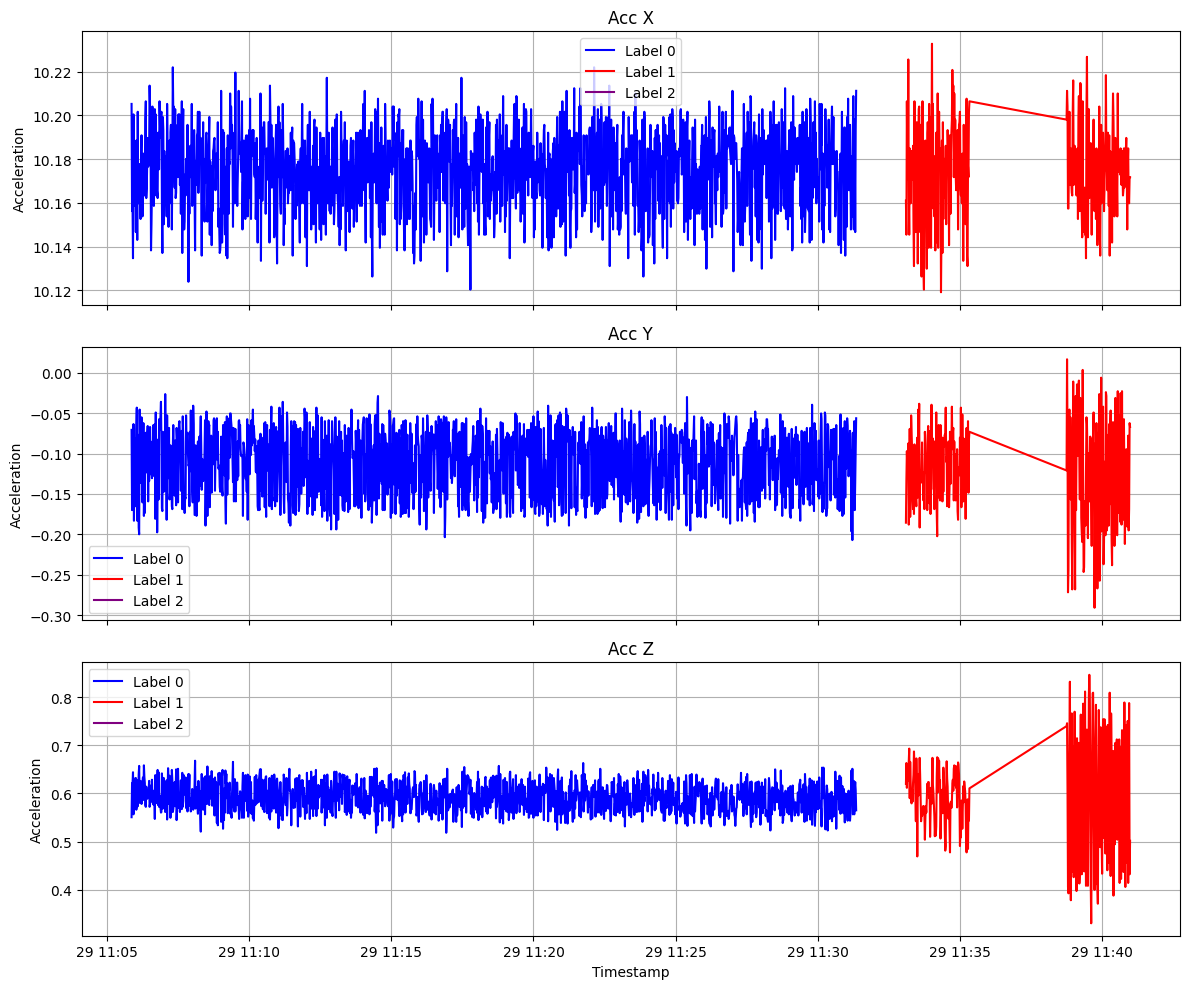

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('../datas/labeled_sensor_data.csv')

# Timestamp를 datetime 형식으로 변환
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

# 마지막 N개의 데이터 선택
N = 10000  # 원하는 개수로 설정
df_last = df.tail(N)

# 그래프 생성
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Label에 따른 색상 설정
colors = {0: 'blue', 1: 'red', 2: 'purple'}  # 정상: 파랑, 이상치 1: 빨강, 이상치 2: 보라

# Acc X
for label, color in colors.items():
    label_data = df_last[df_last['Label'] == label]
    axs[0].plot(label_data['Timestamp'], label_data['Acc X'], label=f'Label {label}', color=color, linestyle='-', marker=None)
axs[0].set_title('Acc X')
axs[0].set_ylabel('Acceleration')
axs[0].legend()  # 범례 추가
axs[0].grid()

# Acc Y
for label, color in colors.items():
    label_data = df_last[df_last['Label'] == label]
    axs[1].plot(label_data['Timestamp'], label_data['Acc Y'], label=f'Label {label}', color=color, linestyle='-', marker=None)
axs[1].set_title('Acc Y')
axs[1].set_ylabel('Acceleration')
axs[1].legend()  # 범례 추가
axs[1].grid()

# Acc Z
for label, color in colors.items():
    label_data = df_last[df_last['Label'] == label]
    axs[2].plot(label_data['Timestamp'], label_data['Acc Z'], label=f'Label {label}', color=color, linestyle='-', marker=None)
axs[2].set_title('Acc Z')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Acceleration')
axs[2].legend()  # 범례 추가
axs[2].grid()

# 그래프 간 여백 조정 및 출력
plt.tight_layout()
plt.show()


## 2. 데이터 전처리

### 2 - 0. 함수 정의

In [4]:
# 시각화 함수
def visualize_features(df, features, title="Feature Visualization"):
    """
    하나의 다운 샘플링된 데이터프레임에서 특징을 선택하여 시각화.
    Args:
        df (pd.DataFrame): 다운 샘플링된 단일 데이터프레임.
        features (list[str]): 시각화할 특징(column)의 이름 리스트.
        title (str): 그래프 제목.
    """
    if df is None or not isinstance(df, pd.DataFrame):
        raise ValueError("df must be a valid pandas DataFrame")

    # 시각화를 위한 설정
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    # 선택된 특징 시각화
    for feature in features:
        if feature not in df.columns:
            print(f"Feature '{feature}' not found in data. Skipping...")
            continue

        plt.plot(
            df["Timestamp"],
            df[feature],
            label=feature
        )
    
    # 그래프 꾸미기
    plt.title(title)
    plt.xlabel("Timestamp (ms)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1. feature selecting 함수
def feature_select(df, features):
    """
    주어진 DataFrame에서 선택된 feature들만 추출하여 반환하는 함수.

    Parameters:
        df (pd.DataFrame): 원본 DataFrame
        selected_features (list): 선택할 feature 이름들의 리스트

    Returns:
        pd.DataFrame: 선택된 feature들로 구성된 DataFrame
    """
    # 선택된 feature들이 데이터프레임에 있는지 확인
    missing_features = [feature for feature in features if feature not in df.columns]
    if missing_features:
        raise ValueError(f"다음 feature들이 데이터프레임에 존재하지 않습니다: {missing_features}")
    
    # 선택된 feature들만 포함한 데이터프레임 생성
    filtered_df = df[features]
    return filtered_df


# 4. 스케일링
def scale_selected_features_multiple_dfs(dfs, features_to_scale, scaler_exist=None):
    """
    여러 데이터프레임에 대해 특정 feature만 스케일링하는 함수.
    
    Args:
        dfs (list of pd.DataFrame): 스케일링할 데이터프레임 리스트
        features_to_scale (list): 스케일링할 칼럼 이름 리스트
    
    Returns:
        list of pd.DataFrame: 스케일링된 데이터프레임 리스트
    """

    # 1. 특정 피처만 뽑아서 하나의 데이터프레임으로 합치기
    combined_df = pd.concat([df[features_to_scale] for df in dfs], ignore_index=True)

    # 2. Min-Max 스케일링 적용
    if scaler_exist == None:
        scaler = MinMaxScaler()
        scaled_combined = scaler.fit_transform(combined_df)
    else:
        scaler = scaler_exist
        scaled_combined = scaler.transform(combined_df)
    
    
    # 스케일링된 값을 DataFrame으로 변환
    scaled_combined_df = pd.DataFrame(scaled_combined, columns=features_to_scale)

    # 3. 원본 데이터프레임 인덱스를 기준으로 분할
    start_idx = 0
    scaled_dfs = []
    for df in dfs:
        # timestamp 칼럼을 원본 그대로 유지하고, 나머지 칼럼은 스케일링된 값으로 교체
        df_scaled = df.drop(columns=features_to_scale)  # 스케일링할 칼럼만 제외
        scaled_df = scaled_combined_df.iloc[start_idx:start_idx + len(df)].reset_index(drop=True)
        df_scaled[features_to_scale] = scaled_df[features_to_scale]  # 스케일링된 값을 추가
        
        # timestamp 값을 유지한 상태로 원본 데이터프레임을 복원
        df_scaled['Timestamp'] = df['Timestamp'].reset_index(drop=True)
        scaled_dfs.append(df_scaled)
        start_idx += len(df)
    
    return scaled_dfs, scaler


### 2 - 1. 데이터프레임들 불러오기

In [5]:
file_path = '/home/cnserver/projects/AI/datas/labeled_sensor_data.csv'

df_list = []

df = pd.read_csv(file_path)
df_list.append(df)

### 2 - 2. Feature Selection

In [6]:
df_list_filtered = []
for df in df_list:
    filtered_df = feature_select(df, ['Timestamp', 'Acc X', 'Acc Y', 'Acc Z', 'Label']) # <--- 이 부분을 필요에 맞게 수정할 것
    df_list_filtered.append(filtered_df)
    

In [7]:
for df in df_list_filtered:
    print(df.head(5))

       Timestamp      Acc X     Acc Y     Acc Z  Label
0  1732878352000  10.205285 -0.070629  0.550666      0
1  1732878353000  10.156203 -0.169988  0.621295      0
2  1732878354000  10.159795 -0.135272  0.618901      0
3  1732878355000  10.134656 -0.141258  0.644040      0
4  1732878356000  10.200497 -0.063446  0.556652      0


### 2 - 4. scaling

In [8]:
df_list_scaled, scaler = scale_selected_features_multiple_dfs(df_list_filtered, ['Acc X', 'Acc Y', 'Acc Z'])

In [9]:
for df in df_list_scaled:
    print(df)

          Timestamp  Label     Acc X     Acc Y     Acc Z
0     1732878352000      0  0.757900  0.715953  0.426914
1     1732878353000      0  0.326312  0.392996  0.563805
2     1732878354000      0  0.357893  0.505837  0.559165
3     1732878355000      0  0.136841  0.486381  0.607889
4     1732878356000      0  0.715794  0.739300  0.438515
...             ...    ...       ...       ...       ...
1795  1732880455000      1  0.578945  0.692607  0.162413
1796  1732880456000      1  0.368417  0.311284  0.461717
1797  1732880457000      1  0.357893  0.396887  0.886311
1798  1732880458000      1  0.463161  0.743191  0.197216
1799  1732880459000      1  0.463161  0.727626  0.331787

[1800 rows x 5 columns]


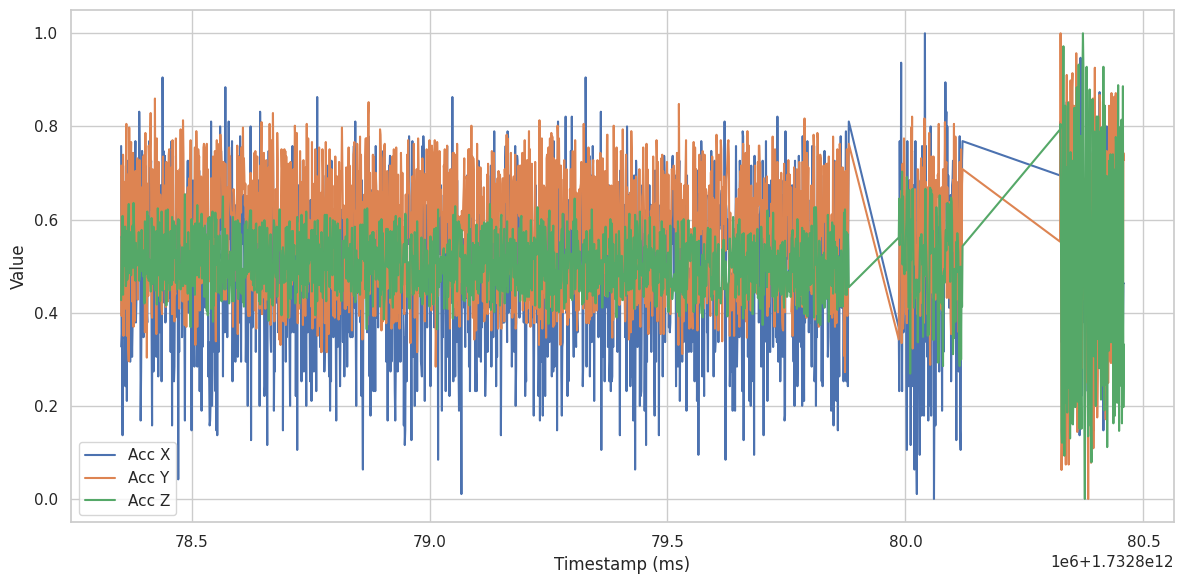

          Timestamp  Label     Acc X     Acc Y     Acc Z
0     1732878352000      0  0.757900  0.715953  0.426914
1     1732878353000      0  0.326312  0.392996  0.563805
2     1732878354000      0  0.357893  0.505837  0.559165
3     1732878355000      0  0.136841  0.486381  0.607889
4     1732878356000      0  0.715794  0.739300  0.438515
...             ...    ...       ...       ...       ...
1795  1732880455000      1  0.578945  0.692607  0.162413
1796  1732880456000      1  0.368417  0.311284  0.461717
1797  1732880457000      1  0.357893  0.396887  0.886311
1798  1732880458000      1  0.463161  0.743191  0.197216
1799  1732880459000      1  0.463161  0.727626  0.331787

[1800 rows x 5 columns]


In [10]:
for df in df_list_scaled:
    visualize_features(df, ['Acc X', 'Acc Y', 'Acc Z'], title='')
    print(df)

# 3. 데이터셋 준비

In [11]:
# 데이터 불러오기
data = df_list_scaled[0]

# 1. Timestamp 제거
data = data.drop(columns=["Timestamp"])

anomaly1_start_idx = 1530
anomaly1_end_idx = 1664
anomaly2_start_idx = 1665
anomaly2_end_idx = 1799

# 2. 정상 데이터와 이상 데이터 분리
# Label 0: 정상, Label 1: 이상치 1, Label 2: 이상치 2
# (시작과 끝 timestamp 기반으로 설정. 예: 25분 ~ 27분 30초: Label 1, 27분 30초 ~ 30분: Label 2)
normal_data = data[data["Label"] == 0]
anomaly1_data = data[(data.index >= anomaly1_start_idx) & (data.index <= anomaly1_end_idx)]
anomaly2_data = data[(data.index >= anomaly2_start_idx) & (data.index <= anomaly2_end_idx)]

# 3. 이상 데이터 덩어리로 나누기 (연속성을 유지하기 위해 최소 길이 설정)
def split_into_chunks(data, min_chunk_size=4):
    chunks = []
    n = len(data)
    indices = np.arange(0, n, min_chunk_size)
    for i in range(len(indices) - 1):
        chunks.append(data.iloc[indices[i] : indices[i + 1]])
    # 마지막 부분 추가
    chunks.append(data.iloc[indices[-1] :])
    return chunks

anomaly1_chunks = split_into_chunks(anomaly1_data, min_chunk_size=min_chunk_size)
anomaly2_chunks = split_into_chunks(anomaly2_data, min_chunk_size=min_chunk_size)

# 4. 정상 데이터와 이상 데이터 섞기
# 이상 데이터의 연속성을 유지하면서 랜덤하게 섞기
mixed_data = normal_data.copy()

for chunk in anomaly1_chunks + anomaly2_chunks:
    insert_idx = np.random.randint(0, len(mixed_data) - len(chunk))  # 랜덤 삽입 위치
    mixed_data = pd.concat([mixed_data.iloc[:insert_idx], chunk, mixed_data.iloc[insert_idx:]]).reset_index(drop=True)



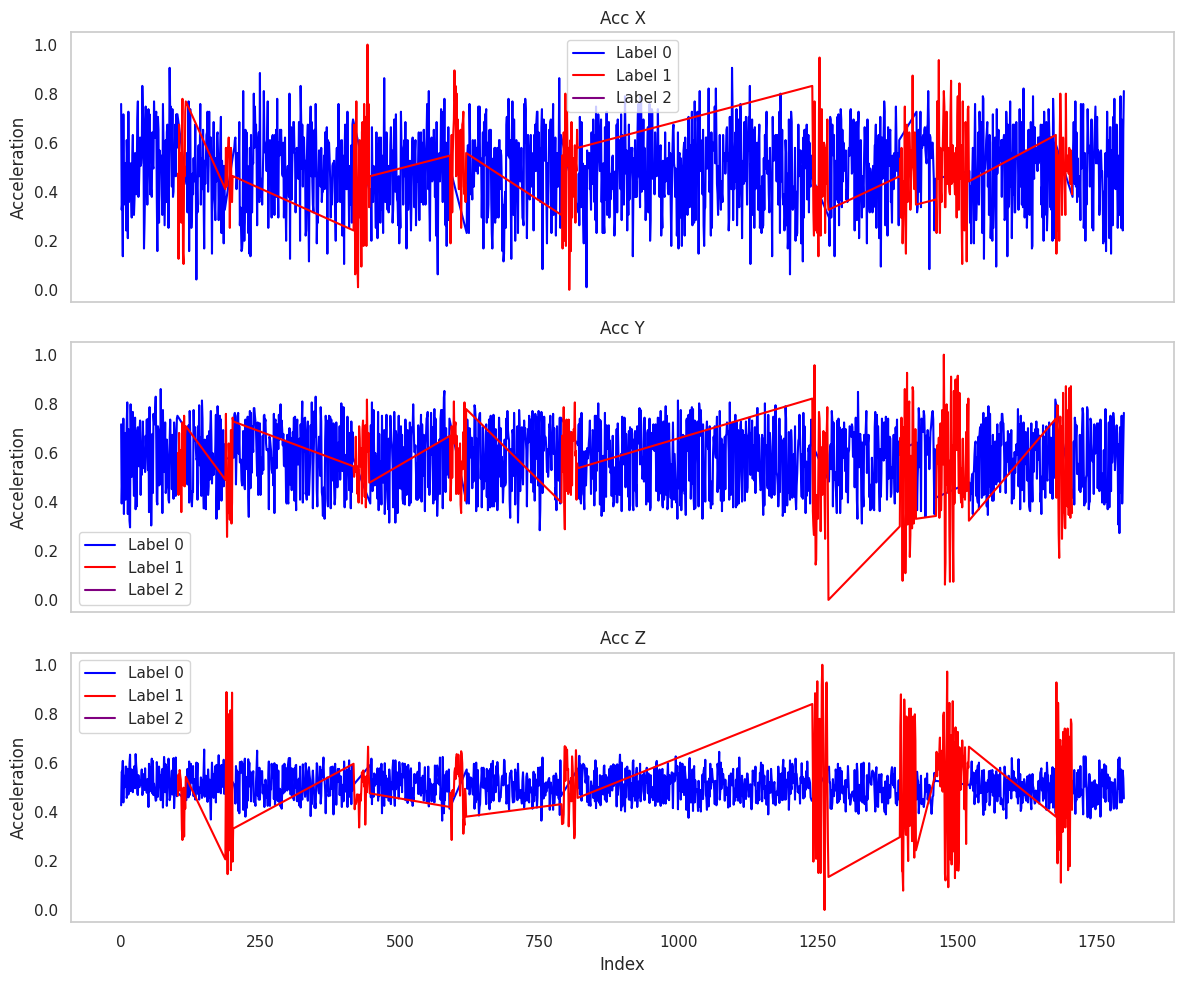

In [12]:


# 섞인 데이터 로드
df = mixed_data

# 그래프 생성
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Label에 따른 색상 설정
colors = {0: 'blue', 1: 'red', 2: 'purple'}  # 정상: 파랑, 이상치 1: 빨강, 이상치 2: 보라

# Acc X
for label, color in colors.items():
    label_data = df[df['Label'] == label]
    axs[0].plot(label_data.index, label_data['Acc X'], label=f'Label {label}', color=color, linestyle='-', marker=None)
axs[0].set_title('Acc X')
axs[0].set_ylabel('Acceleration')
axs[0].legend()  # 범례 추가
axs[0].grid()

# Acc Y
for label, color in colors.items():
    label_data = df[df['Label'] == label]
    axs[1].plot(label_data.index, label_data['Acc Y'], label=f'Label {label}', color=color, linestyle='-', marker=None)
axs[1].set_title('Acc Y')
axs[1].set_ylabel('Acceleration')
axs[1].legend()  # 범례 추가
axs[1].grid()

# Acc Z
for label, color in colors.items():
    label_data = df[df['Label'] == label]
    axs[2].plot(label_data.index, label_data['Acc Z'], label=f'Label {label}', color=color, linestyle='-', marker=None)
axs[2].set_title('Acc Z')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Acceleration')
axs[2].legend()  # 범례 추가
axs[2].grid()

# 그래프 간 여백 조정 및 출력
plt.tight_layout()
plt.show()


In [13]:
mixed_data

,Label,Acc X,Acc Y,Acc Z
0,0,0.757900,0.715953,0.426914
1,0,0.326312,0.392996,0.563805
2,0,0.357893,0.505837,0.559165
3,0,0.136841,0.486381,0.607889
4,0,0.715794,0.739300,0.438515
...,...,...,...,...
1795,0,0.694737,0.750973,0.438515
1796,0,0.600002,0.392996,0.542923
1797,0,0.242100,0.505837,0.568445
1798,0,0.652631,0.645914,0.535963


In [14]:
input_X = mixed_data.loc[:, df.columns != 'Label'].values   # converts the df to a numpy array
input_y = mixed_data['Label'].values

n_features = input_X.shape[1]   # number of features

In [15]:
print(input_X.shape)
print(input_y.shape)
print(n_features)

(1800, 3)
(1800,)
3


In [16]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [17]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-lookback):(np.where(np.array(input_y) == 1)[0][0]+1), ])

# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print(f'For the same instance of y = 1, we are keeping past {lookback} samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,Label,Acc X,Acc Y,Acc Z
92,0,0.736843,0.673152,0.470998
93,0,0.378950,0.486381,0.526682
94,0,0.399998,0.412451,0.619490
95,0,0.557896,0.723735,0.415313
96,0,0.505266,0.677043,0.470998
97,0,0.673688,0.599222,0.563805
98,0,0.463161,0.424125,0.621810
99,0,0.715794,0.630350,0.524362
100,0,0.578945,0.739300,0.464037
101,0,0.715794,0.750973,0.477958


For the same instance of y = 1, we are keeping past 10 samples in the 3D predictor array, X.


,0,1,2
0,0.378950,0.486381,0.526682
1,0.399998,0.412451,0.619490
2,0.557896,0.723735,0.415313
3,0.505266,0.677043,0.470998
4,0.673688,0.599222,0.563805
5,0.463161,0.424125,0.621810
6,0.715794,0.630350,0.524362
7,0.578945,0.739300,0.464037
8,0.715794,0.750973,0.477958
9,0.473685,0.599222,0.466357


In [18]:
print(len(X))
print(len(y))

1789
1789


In [19]:
X_test, X_train, y_test, y_train = train_test_split(np.array(X), np.array(y), test_size=0.9)
X_valid, X_train, y_valid, y_train = train_test_split(X_train, y_train, test_size=0.9)
X_train.shape

X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

X_train_y0.shape

(1227, 10, 1, 3)

In [20]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [21]:
print(X_train_y0.shape)
print()

(1227, 10, 3)



## 3. 모델 학습

In [22]:
# 이 데이터들로 온도 모델 학습시켜 보기

model = create_lstm_autoencoder(lookback, 'vibration')

2024-11-30 22:41:16.063720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 22:41:16.097062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 22:41:16.097215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습
history = model.fit(
    x = X_train_y0,
    y = X_train_y0,
    epochs=epoch,
    batch_size=batch_size,
    validation_data=(X_valid_y0, X_valid_y0),
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30


2024-11-30 22:41:19.030445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-30 22:41:19.045334: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x34b38fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-30 22:41:19.045348: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-30 22:41:19.047889: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 22:41:19.063002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-11-30 22:41:19.090599: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support

20/20 [==============================] - 3s 33ms/step - loss: 0.2169 - mse: 0.2169 - val_loss: 0.0964 - val_mse: 0.0964
Epoch 2/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0869 - mse: 0.0869 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 3/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0621 - mse: 0.0621 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 4/30
20/20 [==============================] - 0s 23ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 5/30
20/20 [==============================] - 0s 20ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 6/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 7/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 8/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0169 - mse: 0.0169 

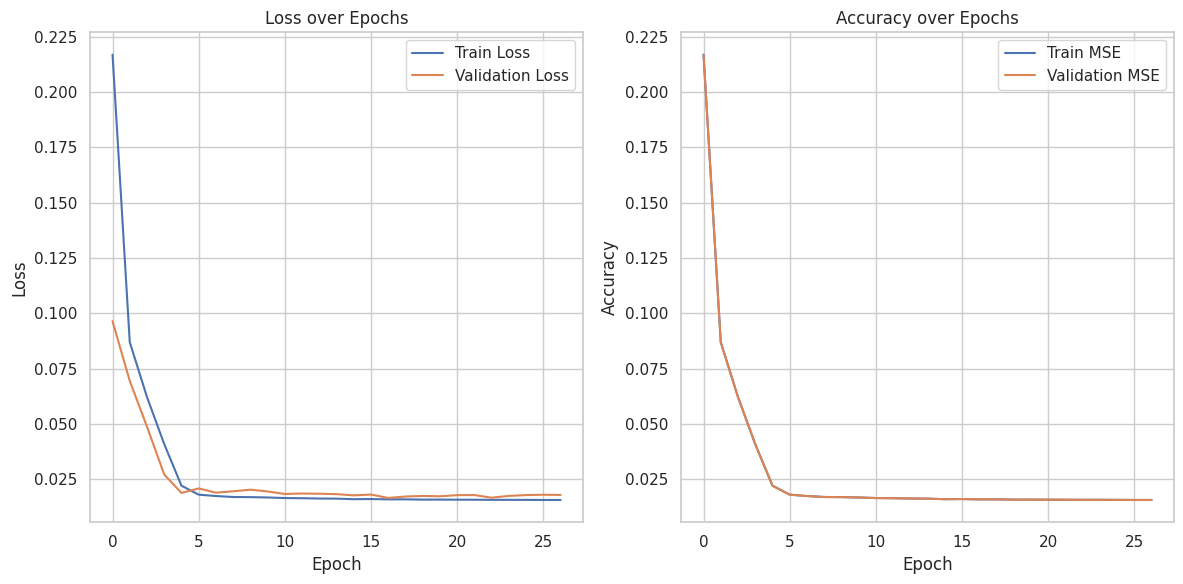

In [24]:
plt.figure(figsize=(12, 6))

# 학습 손실
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='Train Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['mse'], label='Train MSE')
plt.plot(history.epoch, history.history['mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

# testing

In [25]:
from tensorflow.keras.losses import mae

reconstruction = model.predict(X_test)
threshold = 0.1


6/6 [==============================] - 0s 2ms/step


In [26]:
print(reconstruction.shape)
print(y_test.shape)

(178, 10, 3)
(178,)


In [27]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, fbeta_score, accuracy_score, precision_score, recall_score

# prediction은 3차원 (batch_size, timesteps, features), y_test는 1차원 (batch_size,)
# 예측 값과 실제 값 사이의 오차 계산
# 예시로 reconstruction error를 계산한다고 가정

# Step 1: 예측된 오차 계산
recon_error = np.abs(reconstruction - X_test)  # y_test를 3차원으로 확장

# Step 2: 오차의 평균을 계산 (batch_size, timesteps)
mean_error = np.mean(recon_error, axis=(1, 2))  # timesteps 차원을 기준으로 평균을 구함

# Step 3: Threshold 기반 레이블링
threshold = 0.1  # 이 값은 사용자가 설정한 threshold
labels = np.where(mean_error > threshold, 1, 0)  # 오차가 threshold를 넘으면 1 (이상치), 아니면 0 (정상)

# 결과 레이블링
print("Predicted labels based on threshold:", labels)

y_test.shape



Predicted labels based on threshold: [1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1
 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1
 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1
 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1
 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0]


(178,)

In [28]:
thresholds = np.linspace(0, np.max(mean_error), 100)  # 0부터 최대 오류까지 100개의 threshold 시도
fbeta_scores = []
beta = 1
for threshold in thresholds:
    # threshold를 기준으로 이상치 예측
    labels_pred = (mean_error > threshold).astype(int)
    
    # F2 score 계산
    fbeta = fbeta_score(y_test, labels_pred, beta=beta)
    fbeta_scores.append(fbeta)

# 최적의 threshold 찾기
optimal_threshold = thresholds[np.argmax(fbeta_scores)]
print("최적의 threshold:", optimal_threshold)


# 최적 threshold에서의 F2 score 출력
print(f"최고의 F{beta} score:", max(fbeta_scores))

# 최적 threshold를 기준으로 예측값 생성
labels_pred = (mean_error > optimal_threshold).astype(int)

# Confusion Matrix 출력
conf_matrix = confusion_matrix(y_test, labels_pred)
print("Confusion Matrix:")
print(conf_matrix)

# 추가적으로 정확도, 정밀도, 재현율, F2-score 계산
accuracy = accuracy_score(y_test, labels_pred)
precision = precision_score(y_test, labels_pred)
recall = recall_score(y_test, labels_pred)
f2 = fbeta_score(y_test, labels_pred, beta=2)

print("\n정확도:", accuracy)
print("정밀도:", precision)
print("재현율:", recall)
print("F2 score:", f2)

최적의 threshold: 0.1337859748243668
최고의 F1 score: 0.8
Confusion Matrix:
[[157   1]
 [  6  14]]

정확도: 0.9606741573033708
정밀도: 0.9333333333333333
재현율: 0.7
F2 score: 0.7368421052631579
